Fudan CCDC model:

$$
\begin{aligned}
\frac{\mathrm{d} I}{\mathrm{d} t} &= r I_{0}(t) \\
\frac{\mathrm{d} J}{\mathrm{d} t} &= r \int_{-\infty}^{t} f_{4}(t-s) I_{0}(s) \mathrm{d} s \\
\frac{\mathrm{d} G}{\mathrm{d} t} &= \ell(t) \left[ \int_{-\infty}^{t} f_{2}(t-s) I_{0}(s) d s - \int_{-\infty}^{t} f_{4}(t-s) I_{0}(s) \mathrm{d} s \right] \\
\end{aligned}
$$

- $I(t)$: the cumulative number of the infected at time $t$;

- $J(t)$: the cumulative number of confirmed in hospitalization stage at time $t$;

- $G(t)$: the number of infected and isolated but yet diagnosed cases at time $t$. They are infected in fact, but are not conﬁrmed by the hospital, then not appeared in the infected list of CCDC;

- $I_{0}(t) := I(t) - J(t) - G(t)$: the number of unconfirmed/unobserved infected at time $t$;


<div align="center">
Fudan CCDC's graphical model<br>
<img src="fudanCCDC.png" alt="png" title="Fudan CCDC" width=20%>
</div>

[The reproductive number R0 of COVID-19 based on estimate of a statistical time delay dynamical system][1]

[CoVID-19 in Japan: What could happen in the future?][2]


[1]:https://www.medrxiv.org/content/10.1101/2020.02.17.20023747v2
[2]:https://www.medrxiv.org/content/10.1101/2020.02.21.20026070v2

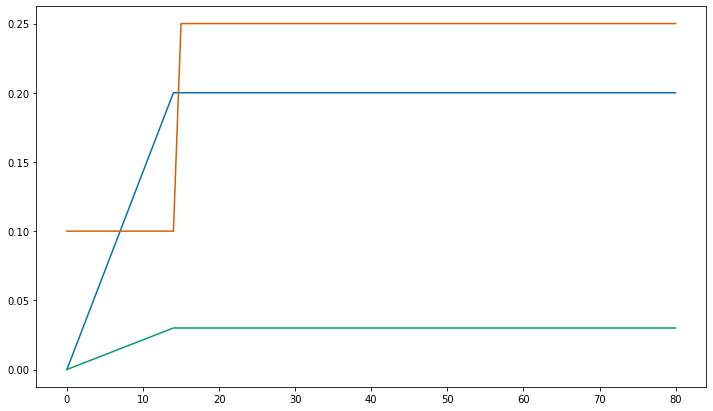

,Days,Cumulative Infected,Observed Infected,Isolated Infected,Potential Infected,PCR Test Posives A,PCR Test Posives B,PCR Test
0,2020-02-14,210,21,0e+00,189,21,21,14
1,2020-02-15,269,21,4e-02,248,21,21,0
2,2020-02-16,327,21,3e-01,306,21,21,0
3,2020-02-17,386,22,1e+00,363,46,38,273
4,2020-02-18,444,22,2e+00,420,53,44,36
5,2020-02-19,503,24,5e+00,475,60,50,71
6,2020-02-20,600,26,9e+00,565,70,60,90
7,2020-02-21,771,30,2e+01,723,79,69,90
8,2020-02-22,946,37,3e+01,880,90,80,85
9,2020-02-23,1155,45,4e+01,1065,114,102,96


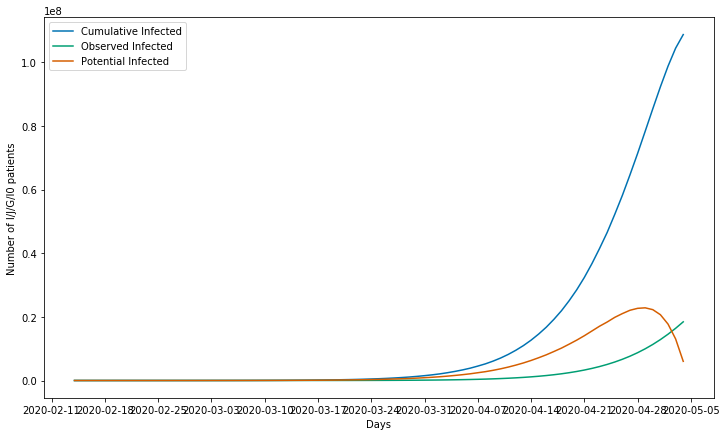

In [1]:
#ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#import packages
import optuna
import numpy as np
import pandas as pd
from ddeint import ddeint
import scipy.integrate as integrate
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')
%matplotlib inline
%load_ext autotime

observation = 'COVID-19.csv'
solition_output  = 'predict_japan.csv'
observed_J = pd.read_csv(observation)

#parameters
t_max = 80
growth_rate = 0.31
incidence_rate = 0.2
confirmation_rate = 0.03
isolation_rate = 0.25
J0 = 21 #start day = 2020-02-14
I0 = J0 * 10
G0 = 0
l1 = 0.1
l2 = isolation_rate

#set timespan
tspan = np.linspace(0, t_max, t_max+1)

#dynamic parameters
def states_before_init(t):
    factor = np.exp(-t**2)
    return [I0 * factor, J0 * factor, G0 * factor]

def f2(t):
    return np.minimum(incidence_rate/14 * t, incidence_rate)

def f4(t):
    return np.minimum(confirmation_rate/14 * t, confirmation_rate)

def lt(t):
    return np.where(t < 15, l1, l2)

f2map = map(lambda x: f2(x), tspan)
f4map = map(lambda x: f4(x), tspan)
ltmap = map(lambda x: lt(x), tspan)

#plot dynamic parameters
rcParams['figure.figsize'] = 12, 7
plt.plot(tspan, list(f2map))
plt.plot(tspan, list(f4map))
plt.plot(tspan, list(ltmap))
plt.show()

#differential equation: Fudan CCDC model
def Fudan_CCDC(v, t):
    #I0 must be positive
    I0 = np.maximum(v(t)[0] - v(t)[1] - v(t)[2], 0)
    #I0 at time s must be positive
    Integral2, _ = integrate.quad(lambda s: f2(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)
    Integral4, _ = integrate.quad(lambda s: f4(t - s) * np.maximum(v(s)[0] - v(s)[1] - v(s)[2], 0), 0, t)

    dI = growth_rate * I0
    dJ = growth_rate * Integral4
    dG = lt(t) * (Integral2 - Integral4)
    
    return np.array([dI, dJ, dG])

solution = ddeint(Fudan_CCDC, states_before_init, tspan)
df_solution = pd.DataFrame({'Days': pd.date_range('2020-2-14', periods = t_max + 1, freq='D'),
                            'Cumulative Infected': solution[:, 0],
                            'Observed Infected': solution[:, 1],
                            'Isolated Infected': solution[:, 2],
                            'Potential Infected': np.maximum(solution[:, 0] - solution[:, 1] - solution[:, 2], 0)})
df_solution['PCR Test Posives A'] = observed_J['A']
df_solution['PCR Test Posives B'] = observed_J['B']
df_solution['PCR Test'] = observed_J['PCR']
df_solution.to_csv(solition_output, index=False)

#display table
pd.options.display.precision = 0
display(df_solution.head(25))

#plot optimal solutions
rcParams['figure.figsize'] = 12, 7
fig, ax = plt.subplots()
ax.plot(df_solution['Days'], df_solution.iloc[:,[1,2,4]])
ax.legend(['Cumulative Infected', 'Observed Infected', 'Potential Infected'])
ax.set_xlabel('Days')
ax.set_ylabel('Number of I/J/G/I0 patients')
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.show()
